In [6]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [ ]:
# Model or Network
import impl.layer as l

class GRU:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters weights and biases
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wr=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            br=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        #         q = 1-p_dropout
        #         u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX

    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX

    # p_dropout = keep_prob in this case! 
    # Is this true in other cases as well?
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = mask * h + (1 - mask) * alpha_p
        a = 1. / np.sqrt(q + alpha_p ** 2 * q  * (1 - q))
        b = -a * (1 - q) * alpha_p
        out = a * dropped + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh
    
    def forward(self, X, h, m, train, with_res):
        Wz, Wr, Wh, Wy = m['Wz'], m['Wr'], m['Wh'], m['Wy']
        bz, br, bh, by = m['bz'], m['br'], m['bh'], m['by']

        X_one_hot = X.copy()
        h_old = h.copy()

        X = np.column_stack((h_old, X_one_hot))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hr, hr_cache = l.fc_forward(X, Wr, br)
        hr, hr_sigm_cache = l.sigmoid_forward(hr)

        X_prime = np.column_stack((hr * h_old, X_one_hot))
        hh, hh_cache = l.fc_forward(X_prime, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = (1. - hz) * h_old + hz * hh
        y, y_cache = l.fc_forward(h, Wy, by)
        
        # residual connection between the output and the input
        # x = x + f(x), f(x) = y, x: input, and y: output
        if with_res:
            y += X_one_hot # y_1xh and x_1xh
        
        if train: 
            #             y, do_cache = self.dropout_forward(X=y, p_dropout=self.p_dropout)
            y, y_nl_cache = self.selu_forward(y)
            y, y_do_cache = self.alpha_dropout_fwd(y, q=self.p_dropout)
            cache = (X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, 
                     hh_tanh_cache, y_cache, y_nl_cache, y_do_cache)
        else: # not train but test
            cache = (X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, 
                     hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache, train, with_res):
        if train: # include dropout_cache/do_cache
            X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_nl_cache, y_do_cache = cache
            #             dy = self.dropout_backward(dout=dy, cache=do_cache)
            dy = self.alpha_dropout_bwd(dy, cache=y_do_cache)
            dy = self.selu_backward(dy, y_nl_cache)
        else: # not train but test
            X, X_prime, h_old, hz, hz_cache, hz_sigm_cache, hr, hr_cache, hr_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_next = dh.copy()
        
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next

        dhh = hz * dh
        dh_old1 = (1. - hz) * dh
        dhz = (hh * dh) - (h_old * dh)

        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dX_prime, dWh, dbh = l.fc_backward(dhh, hh_cache)

        dh_prime = dX_prime[:, :self.H]
        dh_old2 = hr * dh_prime

        dhr = h_old * dh_prime
        dhr = l.sigmoid_backward(dhr, hr_sigm_cache)
        dXr, dWr, dbr = l.fc_backward(dhr, hr_cache)

        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXr + dXz
        dh_old3 = dX[:, :self.H]

        dh = dh_old1 + dh_old2 + dh_old3
        dX = dX[:, self.H:] + dX_prime[:, self.H:]

        # residual connection between the output and the input
        # x = x + f(x), f(x) = y, x: input, and y: output
        if with_res:
            dX += dy

        grad = dict(Wz=dWz, Wr=dWr, Wh=dWh, Wy=dWy, bz=dbz, br=dbr, bh=dbh, by=dby)
        
        return dX, dh, grad
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])

        # self.L is the number of layers in total
        #         layer = 0 # self.L = 1
        for layer in range(self.L):
        #             if layer == 0 and layer == self.L-1: # Input-Output layers
            if layer == 0: # Input-Output layers
                for X in X_train:
                    X_one_hot = np.zeros(self.D)
                    X_one_hot[X] = 1.
                    X = X_one_hot.reshape(1, -1)
                    y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True, with_res=False)
                    caches[layer].append(cache)
                    ys.append(y)
            else:
                X_train = ys.copy()
                ys = []
                for X in X_train:
                    y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True, with_res=True)
                    caches[layer].append(cache)
                    ys.append(y)

        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        for layer in reversed(range(self.L)):
            if layer < (self.L - 1): dys = dXs.copy()
            dXs = []
            #             if layer == 0 and layer == self.L-1: # Input-Output layer
            if layer == 0: # Input-Output layer
                for t in reversed(range(len(dys))):
                    dX = dys[t]
                    dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t], train=True, with_res=False)
                    for key in grad[layer].keys():
                        grads[layer][key] += grad[layer][key]
                    dXs.append(dX)
            else:  # Hidden layers
                for t in reversed(range(len(dys))):
                    dX = dys[t]
                    dX, dh[layer], grad[layer] = self.backward(dX, dh[layer], caches[layer][t], train=True, with_res=True)
                    for key in grad[layer].keys():
                        grads[layer][key] += grad[layer][key]
                    dXs.append(dX)
                
        return dXs, grads
    
    #     def test(self, X_seed, h, size):
    #         chars = [self.idx2char[X_seed]]
    #         idx_list = list(range(self.vocab_size))
    #         X = X_seed

    #         h_init = h.copy()
    #         h = []
    #         for _ in range(self.L):
    #             h.append(h_init.copy())

    #         # Test is different than train since y[t+1] is related to y[t] 
    #         for _ in range(size):
    #             X_one_hot = np.zeros(self.D)
    #             X_one_hot[X] = 1.
    #             X = X_one_hot.reshape(1, -1)
    #             for layer in range(self.L): # start, stop, step
    #                 y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
    #                 if layer == self.L-1: # this is the last layer
    #                     y_logit = y
    #                 else: 
    #                     X = y # y: output for this layer, X: input for this layer
    #             y_prob = l.softmax(y_logit)
    #             idx = np.random.choice(idx_list, p=y_prob.ravel())
    #             chars.append(self.idx2char[idx])
    #             X = idx

    #         return ''.join(chars)

    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        # # Backprop
        # from sklearn.utils import shuffle as skshuffle
        #     if shuffle:
        #         X, y = skshuffle(X, y)

        # for i in range(0, X.shape[0] - minibatch_size +1, 1):
        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam_rnn(self, X_train, y_train, alpha, mb_size, n_iter, print_after):
        M, R = [], []
        for layer in range(nn.L):
            M.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            R.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})

        beta1 = .99
        beta2 = .999
        eps = 1e-8
        state = self.initial_state()
        smooth_loss = 1.0
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False)

        # Epochs
        for iter in range(1, n_iter + 1):

            # No batches/ full batches/ batch files
            # Minibacthes
            for idx in range(len(minibatches)):
                X_mini, y_mini = minibatches[idx]
                ys, caches = self.train_forward(X_mini, state)
                loss, dys = self.loss_function(y_train=y_mini, ys=ys)
                _, grads = self.train_backward(dys, caches)
                self.losses['train'].append(loss)
                smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
                self.losses['smooth train'].append(smooth_loss)

                for layer in range(nn.L):
                    for key in grads[layer].keys(): #key, value: items
                        M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                        R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                        m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                        self.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Print loss and test sample
            if iter % print_after == 0:
                print('Iter-{} loss: {:.4f}'.format(iter, loss))
#                 sample = self.test(X_mini[0], state, size=100)
#                 print(sample)

In [ ]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 400 # depth
n_iter = 13 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//13 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
          p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Smooth train loss')
plt.legend()
plt.show()

Iter-1 loss: 388.7600
Iter-2 loss: 298.5175
Iter-3 loss: 197.5293
Iter-4 loss: 167.2402
Iter-5 loss: 267.9081
Iter-6 loss: 366.1425


Iter-1 loss: 260.7868
Iter-2 loss: 283.7965
Iter-3 loss: 181.5104
Iter-4 loss: 168.2401
Iter-5 loss: 156.1052
Iter-6 loss: 151.2144
Iter-7 loss: 135.2955
Iter-8 loss: 125.9328
Iter-9 loss: 124.2606
Iter-10 loss: 122.4630
Iter-11 loss: 119.5604
Iter-12 loss: 115.1881
Iter-13 loss: 115.6569


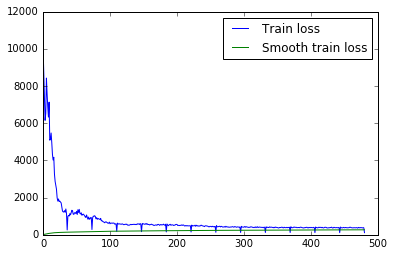

In [3]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 300 # depth
# n_iter = 13 # epochs
# alpha = 1e-4 # learning_rate
# p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
# print_after = n_iter//13 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
#           p_dropout=p_dropout)

# # Start learning using BP-SGD-ADAM
# nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Smooth train loss')
# plt.legend()
# plt.show()

Iter-1 loss: 409.0594
Iter-2 loss: 229.4616
Iter-3 loss: 205.6135
Iter-4 loss: 170.1196
Iter-5 loss: 148.9891
Iter-6 loss: 134.3006
Iter-7 loss: 137.6407
Iter-8 loss: 121.0231
Iter-9 loss: 113.7904
Iter-10 loss: 116.6742
Iter-11 loss: 111.6453
Iter-12 loss: 112.6836
Iter-13 loss: 104.5235


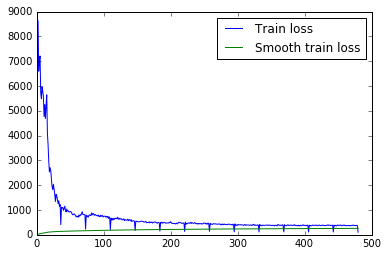

In [5]:
# # # Hyper-parameters
# # time_step = 100 # width, minibatch size and test sample size as well
# # num_layers = 200 # depth
# # n_iter = 13 # epochs
# # alpha = 1e-4 # learning_rate
# # p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
# # print_after = n_iter//13 # print training loss, valid, and test
# # num_hidden_units = 64 # num_hidden_units in hidden layer
# # num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # # Build the network and learning it or optimizing it using SGD
# # nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
# #           p_dropout=p_dropout)

# # # Start learning using BP-SGD-ADAM
# # nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Smooth train loss')
# plt.legend()
# plt.show()

Iter-1 loss: 261.7787
Iter-2 loss: 147.0408
Iter-3 loss: 181.5295
Iter-4 loss: 245.3178
Iter-5 loss: 182.7999
Iter-6 loss: 139.4542
Iter-7 loss: 124.0459
Iter-8 loss: 118.6017
Iter-9 loss: 120.5375
Iter-10 loss: 115.4696
Iter-11 loss: 118.2472
Iter-12 loss: 113.8718
Iter-13 loss: 111.6818


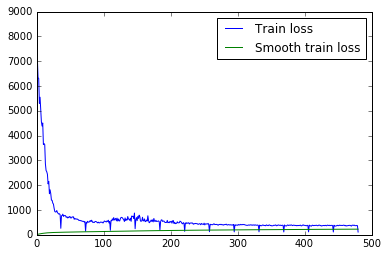

In [4]:
# # # Hyper-parameters
# # time_step = 100 # width, minibatch size and test sample size as well
# # num_layers = 100 # depth
# # n_iter = 13 # epochs
# # alpha = 1e-4 # learning_rate
# # p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
# # print_after = n_iter//13 # print training loss, valid, and test
# # num_hidden_units = 64 # num_hidden_units in hidden layer
# # num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # # Build the network and learning it or optimizing it using SGD
# # nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
# #           p_dropout=p_dropout)

# # # Start learning using BP-SGD-ADAM
# # nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Smooth train loss')
# plt.legend()
# plt.show()

Iter-1 loss: 212.8914
Iter-2 loss: 172.9326
Iter-3 loss: 189.2016
Iter-4 loss: 149.8625
Iter-5 loss: 133.4056
Iter-6 loss: 122.8095
Iter-7 loss: 115.2649
Iter-8 loss: 112.8522
Iter-9 loss: 115.4768
Iter-10 loss: 113.1451
Iter-11 loss: 115.5507
Iter-12 loss: 112.5494
Iter-13 loss: 112.6901


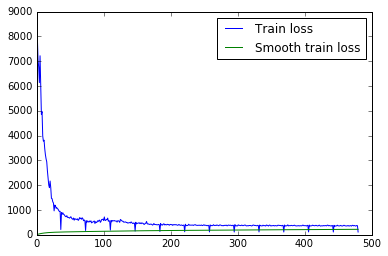

In [4]:
# # # Hyper-parameters
# # time_step = 100 # width, minibatch size and test sample size as well
# # num_layers = 100 # depth
# # n_iter = 13 # epochs
# # alpha = 1e-4 # learning_rate
# # p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
# # print_after = n_iter//13 # print training loss, valid, and test
# # num_hidden_units = 64 # num_hidden_units in hidden layer
# # num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # # Build the network and learning it or optimizing it using SGD
# # nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
# #           p_dropout=p_dropout)

# # # Start learning using BP-SGD-ADAM
# # nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Smooth train loss')
# plt.legend()
# plt.show()